In [1]:
!pip install tensorflow transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 7.9 MB/s eta 0:00:00:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.

In [2]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import subprocess
subprocess.check_call(['pip', 'install', '-q', 'tf_keras'])

0

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from transformers import TFViTForImageClassification, ViTImageProcessor
import os

2025-12-06 20:00:18.874875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765051219.054505      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765051219.108285      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
BATCH_SIZE = 32
IMAGE_SIZE = 224  
NUM_CLASSES = 10  
LEARNING_RATE = 5e-5 
EPOCHS = 6

In [5]:
import shutil
import os

ORIGINAL_DIR = '/kaggle/input/eurosat-dataset/EuroSAT' 


DATA_DIR = '/kaggle/working/EuroSAT_Clean'

if os.path.exists(DATA_DIR):
    shutil.rmtree(DATA_DIR)

print(f"Copying data from {ORIGINAL_DIR} to {DATA_DIR}...")

def ignore_junk(directory, files):
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tif', '.tiff'}
    ignored = []
    for f in files:
        if os.path.isdir(os.path.join(directory, f)):
            if f.startswith('.'):
                ignored.append(f)
            continue
        
        ext = os.path.splitext(f)[1].lower()
        if f.startswith('.') or ext not in valid_extensions:
            ignored.append(f)
    return set(ignored)

shutil.copytree(ORIGINAL_DIR, DATA_DIR, ignore=ignore_junk)

print("Done")
print(f"Update your DATA_DIR variable to: {DATA_DIR}")

Copying data from /kaggle/input/eurosat-dataset/EuroSAT to /kaggle/working/EuroSAT_Clean...
Done
Update your DATA_DIR variable to: /kaggle/working/EuroSAT_Clean


In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

Found 27000 files belonging to 10 classes.
Using 21600 files for training.


I0000 00:00:1765051470.251302      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 27000 files belonging to 10 classes.
Using 5400 files for validation.


In [7]:
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [8]:
def preprocess_data(images, labels):
    images = tf.cast(images, tf.float32)
    images = (images / 127.5) - 1.0
    images = tf.transpose(images, perm=[0, 3, 1, 2])
    
    return {"pixel_values": images}, labels

In [9]:
train_ds = train_ds.map(preprocess_data).shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_data).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
model = TFViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=NUM_CLASSES,
    id2label={str(i): f"Class {i}" for i in range(NUM_CLASSES)},
    label2id={f"Class {i}": i for i in range(NUM_CLASSES)},
    
    # ADD THIS LINE:
    ignore_mismatched_sizes=True 
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageCla

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

print("Starting Training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Starting Training...
Epoch 1/6
675/675 [==============================] - 572s 775ms/step - loss: 0.0237 - accuracy: 0.9923 - val_loss: 0.0685 - val_accuracy: 0.9813
Epoch 2/6
675/675 [==============================] - 531s 769ms/step - loss: 0.0158 - accuracy: 0.9956 - val_loss: 0.0950 - val_accuracy: 0.9743
Epoch 3/6
675/675 [==============================] - 532s 770ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0723 - val_accuracy: 0.9826
Epoch 4/6
675/675 [==============================] - 531s 769ms/step - loss: 0.0168 - accuracy: 0.9945 - val_loss: 0.1196 - val_accuracy: 0.9707
Epoch 5/6
675/675 [==============================] - 530s 769ms/step - loss: 0.0143 - accuracy: 0.9952 - val_loss: 0.0587 - val_accuracy: 0.9859
Epoch 6/6


In [13]:
import os

if 'model' in globals():
    print("Model found in memory! Saving it now...")
    model.save_pretrained("./eurosat_vit_augmented")
    print("✅ Model saved to ./eurosat_vit_augmented")
else:
    print("⚠️ Model variable not found. Did you restart the kernel?")

Model found in memory! Saving it now...
✅ Model saved to ./eurosat_vit_augmented


In [14]:
import shutil
import os
from IPython.display import FileLink


MODEL_DIR = './eurosat_vit_augmented' 
OUTPUT_ZIP_NAME = 'model_final'


if os.path.exists(f"{OUTPUT_ZIP_NAME}.zip"):
    os.remove(f"{OUTPUT_ZIP_NAME}.zip")


if os.path.exists(MODEL_DIR):
    print(f"Zipping folder: {MODEL_DIR} ...")
    

    shutil.make_archive(OUTPUT_ZIP_NAME, 'zip', MODEL_DIR)
    
 
    file_size_mb = os.path.getsize(f"{OUTPUT_ZIP_NAME}.zip") / (1024 * 1024)
    print(f"✅ Success! Zip created. Size: {file_size_mb:.2f} MB")
    
    print("\n⬇️ Click to Download:")
    display(FileLink(f'{OUTPUT_ZIP_NAME}.zip'))
else:
    print(f"❌ Error: The folder '{MODEL_DIR}' does not exist.")
    print("Did you run 'model.save_pretrained()' earlier?")

Zipping folder: ./eurosat_vit_augmented ...
✅ Success! Zip created. Size: 303.84 MB

⬇️ Click to Download:


/kaggle/working/model_final.zip

Loading Test Data (Correctly Mixed)...
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.
Extracting data arrays...
Predicting on 5400 images...
169/169 [==============================] - 45s 251ms/step

✅ True Accuracy: 0.9791 (97.91%)

📊 Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop     0.9926    0.9553    0.9736       559
              Forest     0.9902    0.9919    0.9910       614
HerbaceousVegetation     0.9821    0.9338    0.9574       589
             Highway     0.9840    0.9860    0.9850       499
          Industrial     0.9938    0.9918    0.9928       488
             Pasture     0.9407    0.9695    0.9549       393
       PermanentCrop     0.9470    0.9792    0.9628       529
         Residential     0.9968    0.9890    0.9929       637
               River     0.9683    0.9939    0.9809       491
             SeaLake     0.9820    1.0000    0.9909       601

            accuracy        

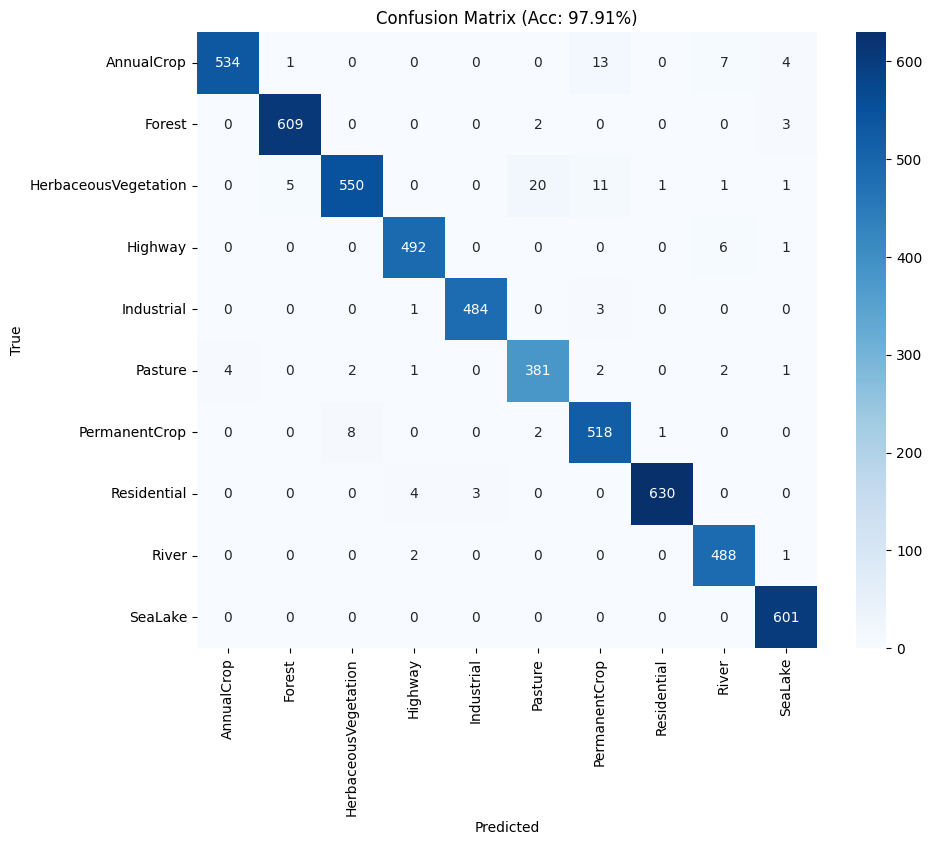

In [6]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

DATA_DIR = '/kaggle/working/EuroSAT_Clean' # Or your input dir
BATCH_SIZE = 32
IMAGE_SIZE = 224
target_names = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
    'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'
]

print("Loading Test Data (Correctly Mixed)...")

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,  # <--- THIS MUST BE TRUE to get all classes
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


all_images = []
all_labels = []

print("Extracting data arrays...")
for images, labels in val_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

X_test = np.concatenate(all_images, axis=0)
y_true = np.concatenate(all_labels, axis=0)


X_test = (X_test / 127.5) - 1.0
X_test = np.transpose(X_test, (0, 3, 1, 2))

print(f"Predicting on {len(y_true)} images...")
# Verbose=1 shows a progress bar
output = model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)
y_pred = np.argmax(output.logits, axis=1)

acc = accuracy_score(y_true, y_pred)
print(f"\n✅ True Accuracy: {acc:.4f} ({acc*100:.2f}%)")

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Acc: {acc:.2%})')
plt.show()

In [7]:
import numpy as np
from sklearn.metrics import jaccard_score, f1_score
import tensorflow as tf
import pandas as pd

DATA_DIR = '/kaggle/working/EuroSAT_Clean'
BATCH_SIZE = 32
IMAGE_SIZE = 224
target_names = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
    'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'
]

print("Loading and extracting validation data...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True, 
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

all_images = []
all_labels = []
for images, labels in val_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

X_test = np.concatenate(all_images, axis=0)
y_true = np.concatenate(all_labels, axis=0)


X_test = (X_test / 127.5) - 1.0
X_test = np.transpose(X_test, (0, 3, 1, 2))

print("Running predictions...")
output = model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)
y_pred = np.argmax(output.logits, axis=1)


iou_scores = jaccard_score(y_true, y_pred, average=None) 


dice_scores = f1_score(y_true, y_pred, average=None)


results_df = pd.DataFrame({
    'Class': target_names,
    'IoU (Jaccard)': iou_scores,
    'Dice (F1)': dice_scores
})


mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)
results_df.loc['Mean'] = ['AVERAGE', mean_iou, mean_dice]

print("\n" + "="*50)
print("     METRICS REPORT (IoU & DICE)")
print("="*50)
print(results_df.to_string(index=False, float_format="%.4f"))
print("="*50)

print(f"\n✅ Mean IoU:  {mean_iou:.4f}")
print(f"✅ Mean Dice: {mean_dice:.4f}")

Loading and extracting validation data...
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.
Running predictions...
169/169 [==============================] - 42s 251ms/step

     METRICS REPORT (IoU & DICE)
               Class  IoU (Jaccard)  Dice (F1)
          AnnualCrop         0.9485     0.9736
              Forest         0.9823     0.9910
HerbaceousVegetation         0.9182     0.9574
             Highway         0.9704     0.9850
          Industrial         0.9857     0.9928
             Pasture         0.9137     0.9549
       PermanentCrop         0.9283     0.9628
         Residential         0.9859     0.9929
               River         0.9625     0.9809
             SeaLake         0.9820     0.9909
             AVERAGE         0.9578     0.9782

✅ Mean IoU:  0.9578
✅ Mean Dice: 0.9782
